# Gensim Model

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gensim-Model" data-toc-modified-id="Gensim-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gensim Model</a></span><ul class="toc-item"><li><span><a href="#Daten-einlesen,-wählen-und-vorbereiten-" data-toc-modified-id="Daten-einlesen,-wählen-und-vorbereiten--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Daten einlesen, wählen und vorbereiten <a name="introduction"></a></a></span></li><li><span><a href="#Gensim-Modell-vorbereiten-" data-toc-modified-id="Gensim-Modell-vorbereiten--1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gensim Modell vorbereiten <a name="paragraph0"></a></a></span></li><li><span><a href="#Topic-Modelling-aller-Daten-mit-raw-text-" data-toc-modified-id="Topic-Modelling-aller-Daten-mit-raw-text--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Topic Modelling aller Daten mit raw text <a name="paragraph1"></a></a></span><ul class="toc-item"><li><span><a href="#Unigramm-" data-toc-modified-id="Unigramm--1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Unigramm <a name="subparagraph1"></a></a></span></li><li><span><a href="#Bigramm-" data-toc-modified-id="Bigramm--1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Bigramm <a name="subparagraph2"></a></a></span></li><li><span><a href="#Trigramm-" data-toc-modified-id="Trigramm--1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Trigramm <a name="subparagraph3"></a></a></span></li></ul></li><li><span><a href="#Ergebnisse-erkunden-" data-toc-modified-id="Ergebnisse-erkunden--1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Ergebnisse erkunden <a name="paragraph4"></a></a></span><ul class="toc-item"><li><span><a href="#Dominante-Topics-pro-Artikels" data-toc-modified-id="Dominante-Topics-pro-Artikels-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Dominante Topics pro Artikels</a></span></li><li><span><a href="#Repräsentativstes-Dokument-pro-Topic" data-toc-modified-id="Repräsentativstes-Dokument-pro-Topic-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Repräsentativstes Dokument pro Topic</a></span></li></ul></li></ul></li></ul></div>

In [13]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases

from gensim.models.phrases import Phraser
import pandas as pd

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Daten einlesen, wählen und vorbereiten <a name="introduction"></a>

In [2]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')
df.head(1)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0


In [3]:
#data1 = df[df['Genre1'] == 'Jazz']
#data2 = df[df['Genre1'] == 'Hip Hop']
#data3 = df[df['Genre1'] == 'Electronic']
#data4 = df[df['Genre1'] == 'Folk, World, & Country']
#genres = pd.concat([data1, data2, data3, data4], axis=0)
#genres.head(1)

## Gensim Modell vorbereiten <a name="paragraph0"></a>

In [4]:
def create_docs(df, column):
    docs = []
    for i, row in df.iterrows():
        text = row[column].split()
        docs.append(text)
    return docs

In [5]:
def build_dictionary(docs):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [6]:
def build_model(docs, num_topics=8, chunksize=2000, passes=20, iterations=400, eval_every=None):
    dictionary, corpus = build_dictionary(docs)
    
    temp = dictionary[0] 
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    return model, dictionary, corpus

In [7]:
# top_topics = model.top_topics(corpus) #, num_words=20)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# pprint(top_topics)

In [8]:
def visualise_LDA(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [9]:
def bi_trigramm(df, column):
    bigram_text= []
    for i, row in df.iterrows():
        text = row[column].split()
        bigram_text.append(text)

    bigram = Phrases(bigram_text, min_count=2, threshold=10) # höherer threshold für weniger phrases.
    trigram = Phrases(bigram[docs], threshold=10)  

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_text, bigram_mod, trigram_mod

## Topic Modelling aller Daten mit raw text <a name="paragraph1"></a>

### Unigramm <a name="subparagraph1"></a>

In [10]:
docs = create_docs(df, 'content')
model, dictionary, corpus = build_model(docs)

In [11]:
print('Unique tokens: %d' % len(dictionary))
print('Documents: %d' % len(corpus))
pprint(model.print_topics())

Unique tokens: 3633
Documents: 2225
[(0,
  '0.023*"Mr" + 0.011*"his" + 0.009*"they" + 0.008*"He" + 0.008*"government" + '
  '0.007*"-" + 0.007*"who" + 0.006*"could" + 0.006*"Labour" + 0.006*"about"'),
 (1,
  '0.014*"more" + 0.013*"broadband" + 0.012*"people" + 0.011*"than" + '
  '0.010*"up" + 0.009*"net" + 0.008*"they" + 0.008*"UK" + 0.008*"million" + '
  '0.008*"or"'),
 (2,
  '0.016*"they" + 0.013*"people" + 0.012*"can" + 0.012*"you" + 0.010*"more" + '
  '0.008*"or" + 0.007*"do" + 0.007*"phone" + 0.007*"use" + 0.007*"-"'),
 (3,
  '0.019*"his" + 0.009*"who" + 0.009*"after" + 0.008*"I" + 0.008*"first" + '
  '0.008*"we" + 0.007*""I" + 0.006*"her" + 0.006*"-" + 0.006*"against"'),
 (4,
  '0.033*"I" + 0.018*"you" + 0.017*"game" + 0.013*"games" + 0.012*"more" + '
  '0.011*"my" + 0.010*"-" + 0.009*"can" + 0.008*"or" + 0.007*"like"'),
 (5,
  '0.010*"music" + 0.010*"more" + 0.009*"its" + 0.008*"people" + '
  '0.008*"technology" + 0.008*"can" + 0.007*"they" + 0.007*"digital" + '
  '0.007*"mobile

In [14]:
# visualise_LDA(model, dictionary, corpus)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.052346 -0.162235       1        1  25.682232
3     -0.202618  0.001676       2        1  20.674763
0     -0.109151 -0.043353       3        1  20.001854
5      0.077842 -0.001573       4        1   8.708294
2      0.066731  0.088794       5        1   8.352010
4     -0.057434  0.180073       6        1   8.020569
1      0.130532 -0.058882       7        1   4.888673
6      0.146444 -0.004501       8        1   3.671613, topic_info=     Category         Freq    Term        Total  loglift  logprob
596   Default  2002.000000       I  2002.000000  30.0000  30.0000
1192  Default  1121.000000     you  1121.000000  29.0000  29.0000
787   Default  1596.000000  people  1596.000000  28.0000  28.0000
2843  Default   737.000000    game   737.000000  27.0000  27.0000
226   Default  2063.000000    more  2063.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
73     Topic8    82.924156     its  2194.935791   0.0286  -5.1407
331    Topic8    82.610161    they  2400.908936  -0.0649  -5.1445
233    Topic8    76.816483     out  1383.462280   0.4136  -5.2172
466    Topic8    74.924713   other   969.005737   0.7448  -5.2421
155    Topic8    71.735214      In   924.820435   0.7479  -5.2856

[596 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
140       1  0.047191    "I
140       2  0.575521    "I
140       3  0.261601    "I
140       5  0.038984    "I
140       6  0.071812    "I
...     ...       ...   ...
1193      4  0.120573  your
1193      5  0.478745  your
1193      6  0.365264  your
1193      7  0.017731  your
1193      8  0.003546  your

[1647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 6, 3, 5, 2, 7])

In [15]:
pyLDAvis.save_html(vis, '../../Bilder/Topic Modeling/lda_text_alles.html')

### Bigramm <a name="subparagraph2"></a>

In [16]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'content')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [19]:
pprint(model.print_topics())

[(0,
  '0.012*"its" + 0.011*"software" + 0.010*"-" + 0.010*"computer" + '
  '0.009*"Apple" + 0.009*"or" + 0.009*"new" + 0.008*"will_be" + 0.007*"their" '
  '+ 0.006*"more"'),
 (1,
  '0.010*"their" + 0.009*"or" + 0.009*"were" + 0.008*"people" + 0.007*"its" + '
  '0.007*"not" + 0.006*"sites" + 0.006*"site" + 0.006*"this" + 0.006*"Mr"'),
 (2,
  '0.015*"were" + 0.014*"its" + 0.011*"more_than" + 0.010*"US" + 0.010*"UK" + '
  '0.009*"market" + 0.008*"sales" + 0.008*"broadband" + 0.008*"people" + '
  '0.007*"over"'),
 (3,
  '0.015*"he" + 0.013*"his" + 0.013*"-" + 0.009*"had" + 0.008*"after" + '
  '0.007*"not" + 0.007*"who" + 0.007*"would" + 0.006*"their" + 0.006*"were"'),
 (4,
  '0.016*"games" + 0.012*"game" + 0.011*"will_be" + 0.011*"-" + 0.010*"more" + '
  '0.008*"Mr" + 0.007*"show" + 0.007*"their" + 0.006*"players" + 0.006*"its"'),
 (5,
  '0.028*"I" + 0.014*"-" + 0.013*"you" + 0.012*"my" + 0.011*"not" + 0.010*"or" '
  '+ 0.008*"this" + 0.008*"more" + 0.008*"just" + 0.008*"an"'),
 (6,
  '0.

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.004693 -0.090204       1        1  49.226608
5      0.064428 -0.128842       2        1  14.784771
6      0.010016  0.008527       3        1  10.332926
1     -0.008613 -0.045942       4        1   7.893328
2     -0.248314  0.124077       5        1   6.129427
0     -0.010648 -0.012156       6        1   5.379388
4     -0.007916 -0.051613       7        1   4.537049
7      0.196354  0.196153       8        1   1.716495, topic_info=    Category         Freq     Term        Total  loglift  logprob
490  Default  1202.000000        I  1202.000000  30.0000  30.0000
61   Default  1607.000000      its  1607.000000  29.0000  29.0000
6    Default  1415.000000      But  1415.000000  28.0000  28.0000
270  Default  1602.000000     were  1602.000000  27.0000  27.0000
117  Default  3014.000000        -  3014.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
263   Topic8    27.371212     them   575.927429   1.0184  -5.1965
571   Topic8    29.518507  will_be  1186.047119   0.3715  -5.1209
396   Topic8    27.907835    their  1977.491699  -0.1958  -5.1770
584   Topic8    24.495901    could   864.984436   0.5007  -5.3074
471   Topic8    24.514193     over   973.876099   0.3829  -5.3067

[594 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
401       1  0.456418    "I
401       2  0.504826    "I
401       3  0.010373    "I
401       4  0.024204    "I
117       1  0.589115     -
...     ...       ...   ...
1075      3  0.147177  your
1075      4  0.013082  your
1075      5  0.019624  your
1075      6  0.130824  your
1075      7  0.029435  your

[1671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 2, 3, 1, 5, 8])

### Trigramm <a name="subparagraph3"></a>

In [21]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [22]:
pprint(model.print_topics())

[(0,
  '0.012*"-" + 0.012*"his" + 0.008*"he" + 0.008*"had" + 0.008*"after" + '
  '0.007*"their" + 0.006*"were" + 0.006*"who" + 0.006*"also" + 0.006*"not"'),
 (1,
  '0.013*"are" + 0.010*"people" + 0.009*"their" + 0.008*"or" + '
  '0.008*"technology" + 0.008*"will" + 0.007*"more" + 0.006*"-" + 0.006*"use" '
  '+ 0.006*"But"'),
 (2,
  '0.014*"are" + 0.011*"people" + 0.011*"their" + 0.010*"or" + 0.007*"this" + '
  '0.007*"they" + 0.007*"about" + 0.006*"use" + 0.006*"were" + 0.006*"not"'),
 (3,
  '0.015*"are" + 0.013*"-" + 0.010*"more" + 0.009*"you" + 0.007*"it_is" + '
  '0.007*"will" + 0.006*"an" + 0.006*"game" + 0.006*"its" + 0.006*"this"'),
 (4,
  '0.039*"Apple" + 0.038*"software" + 0.019*"system" + 0.016*"computer" + '
  '0.015*"legal" + 0.014*"its" + 0.012*"who" + 0.012*"users" + 0.011*"files" + '
  '0.011*"programs"'),
 (5,
  '0.014*"games" + 0.011*"will" + 0.011*"new" + 0.011*"-" + 0.010*"will_be" + '
  '0.009*"its" + 0.007*"more" + 0.007*"game" + 0.007*"music" + 0.007*"also"'),
 (6,

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.036789  0.042959       1        1  48.485676
6     -0.133478  0.164062       2        1  12.305615
7      0.014850 -0.147329       3        1  10.854120
1     -0.020060 -0.048456       4        1   8.587832
2      0.009782  0.045002       5        1   8.121547
3     -0.084199  0.000734       6        1   6.273109
5     -0.053981 -0.116329       7        1   4.013731
4      0.303875  0.059357       8        1   1.358375, topic_info=     Category         Freq      Term        Total  loglift  logprob
60    Default  1491.000000       its  1491.000000  30.0000  30.0000
2355  Default   917.000000         I   917.000000  29.0000  29.0000
228   Default  2152.000000       are  2152.000000  28.0000  28.0000
270   Default  1329.000000       who  1329.000000  27.0000  27.0000
51    Default  1568.000000       had  1568.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
228    Topic8    31.001341       are  2152.825195   0.0584  -4.8152
396    Topic8    29.651350     their  1956.183594   0.1096  -4.8597
78     Topic8    27.738083        or  1508.982422   0.3025  -4.9264
318    Topic8    24.288500  he_said.   564.888916   1.1523  -5.0592
262    Topic8    23.773445      they   949.316833   0.6117  -5.0807

[585 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
400       1  0.382848    "I
400       2  0.584089    "I
400       5  0.014725    "I
400       6  0.014725    "I
3217      1  0.056198  "She
...     ...       ...   ...
1079      2  0.287382  your
1079      4  0.094482  your
1079      5  0.185027  your
1079      6  0.421232  your
1079      7  0.011810  your

[1581 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 8, 2, 3, 4, 6, 5])

## Ergebnisse erkunden <a name="paragraph4"></a>

### Dominante Topics pro Artikels

In [30]:
def dominant_topics(ldamodel, corpus, texts, genre, artist):
    sent_topics_df = pd.DataFrame()


    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)


        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


    contents = pd.Series(texts)
    genres = pd.Series(genre)
    artist = pd.Series(artist)
    sent_topics_df = pd.concat([sent_topics_df, contents, genres, artist], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = dominant_topics(
   ldamodel=model, corpus=corpus, texts=df.content.values, genre=df.category.values, artist=df.filename.values
)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Genre', 'Dateiname'
]


df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Genre,Dateiname
0,0,7.0,0.4752,"its, are, or, -, people, their, were, more_tha...",Quarterly profits at US media giant TimeWarne...,business,001.txt
1,1,0.0,0.8228,"-, his, he, had, after, their, were, who, also...",The dollar has hit its highest level against ...,business,002.txt
2,2,0.0,0.4952,"-, his, he, had, after, their, were, who, also...",The owners of embattled Russian oil giant Yuk...,business,003.txt
3,3,7.0,0.5404,"its, are, or, -, people, their, were, more_tha...",British Airways has blamed high fuel prices f...,business,004.txt
4,4,0.0,0.5209,"-, his, he, had, after, their, were, who, also...",Shares in UK drinks and food firm Allied Dome...,business,005.txt
...,...,...,...,...,...,...,...
2220,2220,2.0,0.6624,"are, people, their, or, this, they, about, use...",BT is introducing two initiatives to help bea...,tech,397.txt
2221,2221,7.0,0.9723,"its, are, or, -, people, their, were, more_tha...",Computer users across the world continue to i...,tech,398.txt
2222,2222,2.0,0.7624,"are, people, their, or, this, they, about, use...",A new European directive could put software w...,tech,399.txt
2223,2223,1.0,0.4453,"are, people, their, or, technology, will, more...",The man making sure US computer networks are ...,tech,400.txt


In [31]:
from collections import Counter
import numpy as np
df1 = df_dominant_topic.groupby(['Dominant_Topic', 'Genre'])['Topic_Perc_Contrib'].apply(list)
topics = df1.to_frame()
for i, row in topics.iterrows():
    row.Topic_Perc_Contrib = len(row.Topic_Perc_Contrib)
topics

Topic_Perc_Contrib
Dominant_Topic Genre                           
0.0            business                     403
               entertainment                251
               politics                     409
               sport                        487
               tech                          11
1.0            business                       4
               entertainment                  3
               sport                          1
               tech                         119
2.0            business                       2
               entertainment                  1
               tech                          71
3.0            business                       1
               entertainment                  3
               politics                       1
               tech                          52
4.0            tech                          13
5.0            entertainment                  8
               politics                       1
               tech                          45
6.0            entertainment                107
               politics                       2
               sport                         23
               tech                          16
7.0            business                     100
               entertainment                 13
               politics                       4
               tech                          74

In [32]:
topics = topics.reset_index()

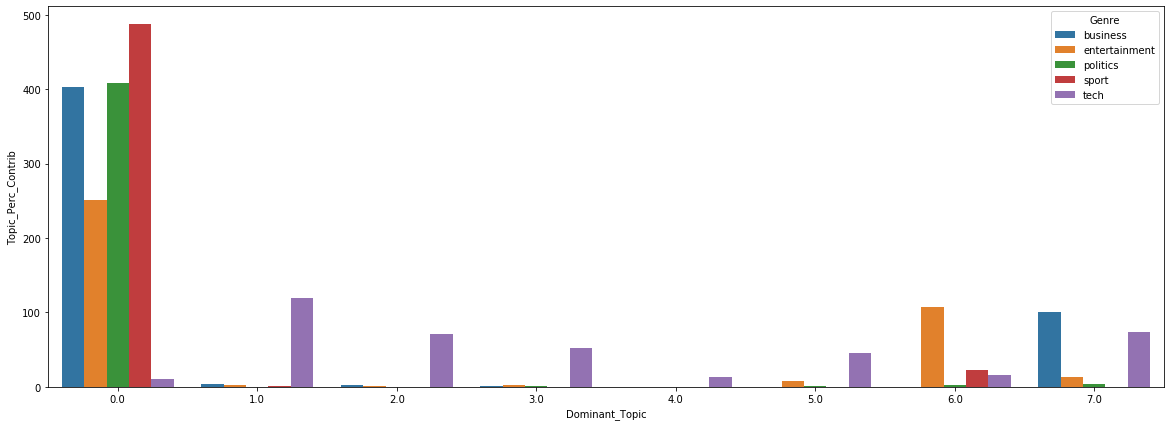

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,7))
sns.barplot(x=topics.Dominant_Topic, y="Topic_Perc_Contrib", hue='Genre',data=topics)
#plt.savefig('../../Bilder/Topic Modeling/topic_modelling_verteilung')
plt.show()

In [39]:
for i, v in Counter(df_dominant_topic[df_dominant_topic.Genre=='tech'].Dominant_Topic).items():
    print(f"Topic {i} tritt {v} mal auf")

Topic 2.0 tritt 71 mal auf
Topic 7.0 tritt 74 mal auf
Topic 1.0 tritt 119 mal auf
Topic 3.0 tritt 52 mal auf
Topic 5.0 tritt 45 mal auf
Topic 0.0 tritt 11 mal auf
Topic 4.0 tritt 13 mal auf
Topic 6.0 tritt 16 mal auf


### Repräsentativstes Dokument pro Topic

In [40]:
import numpy as np
representative = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative = pd.concat([representative, grp.sort_values(['Perc_Contribution']).head(1)], axis=0)
representative.reset_index(drop=True, inplace=True)

representative.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text", "Genre", "Dateiname"
]
representative

,Topic_Number,Contribution_Perc,Keywords,Text,Genre,Dateiname
0,0.0,0.2933,"-, his, he, had, after, their, were, who, also...",US retail giant Federated Department Stores i...,business,155.txt
1,1.0,0.2461,"are, people, their, or, technology, will, more...","After bubbling under for some time, online ga...",tech,157.txt
2,2.0,0.2800,"are, people, their, or, this, they, about, use...",Text messaging technology was a valuable comm...,tech,142.txt
3,3.0,0.3143,"are, -, more, you, it_is, will, an, game, its,...",The 2005 Consumer Electronics Show in Las Veg...,tech,174.txt
4,4.0,0.2412,"Apple, software, system, computer, legal, its,...",The body that represents the US movie industr...,tech,091.txt
5,5.0,0.2651,"games, will, new, -, will_be, its, more, game,...",Xbox video game Halo 2 has been released in t...,tech,139.txt
6,6.0,0.2370,"I, -, my, her, or, his, she, an, he, are",Voting is under way for the annual Bloggies w...,tech,088.txt
7,7.0,0.2446,"its, are, or, -, people, their, were, more_tha...",Musicians are embracing the internet as a way...,tech,145.txt


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer(max_features=1000, min_df=1, max_df=300, stop_words='english')
cv.fit(representative['Keywords'])

results = cv.transform(representative['Keywords'])

features = cv.get_feature_names()

In [49]:
df_res = pd.DataFrame(results.toarray(), columns=features)
# df_res = df_res.set_index(df.genre1)
df_res

,apple,computer,files,game,games,it_is,legal,market,more_than,music,new,people,programs,software,technology,use,users,will_be
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0
5,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0


In [50]:
df_res.loc['sum']=df_res.sum()
df_res = df_res.div(df_res.sum(axis=1), axis=0)
df_res.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
df_res

,people,game,use,apple,new,users,technology,software,programs,music,computer,more_than,market,legal,it_is,games,files,will_be
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000
5,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
sum,0.136364,0.090909,0.090909,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455


In [54]:
genre = df_res[df_res.index==1]
genre.loc['sum']=genre.sum()
genre = genre.div(genre.sum(axis=1), axis=0)
genre.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
genre

,people,use,technology,computer,files,games,it_is,legal,market,more_than,music,game,programs,software,users,new,apple,will_be
1,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


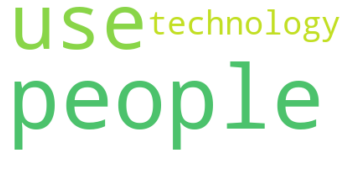

In [55]:
from wordcloud import WordCloud

def makeImage(text, figname):
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(figname)
    plt.show()

text = genre.loc['sum']
# text = abba.any()
makeImage(text, "../../Bilder/Topic Modeling/wordcloud_Topic1")